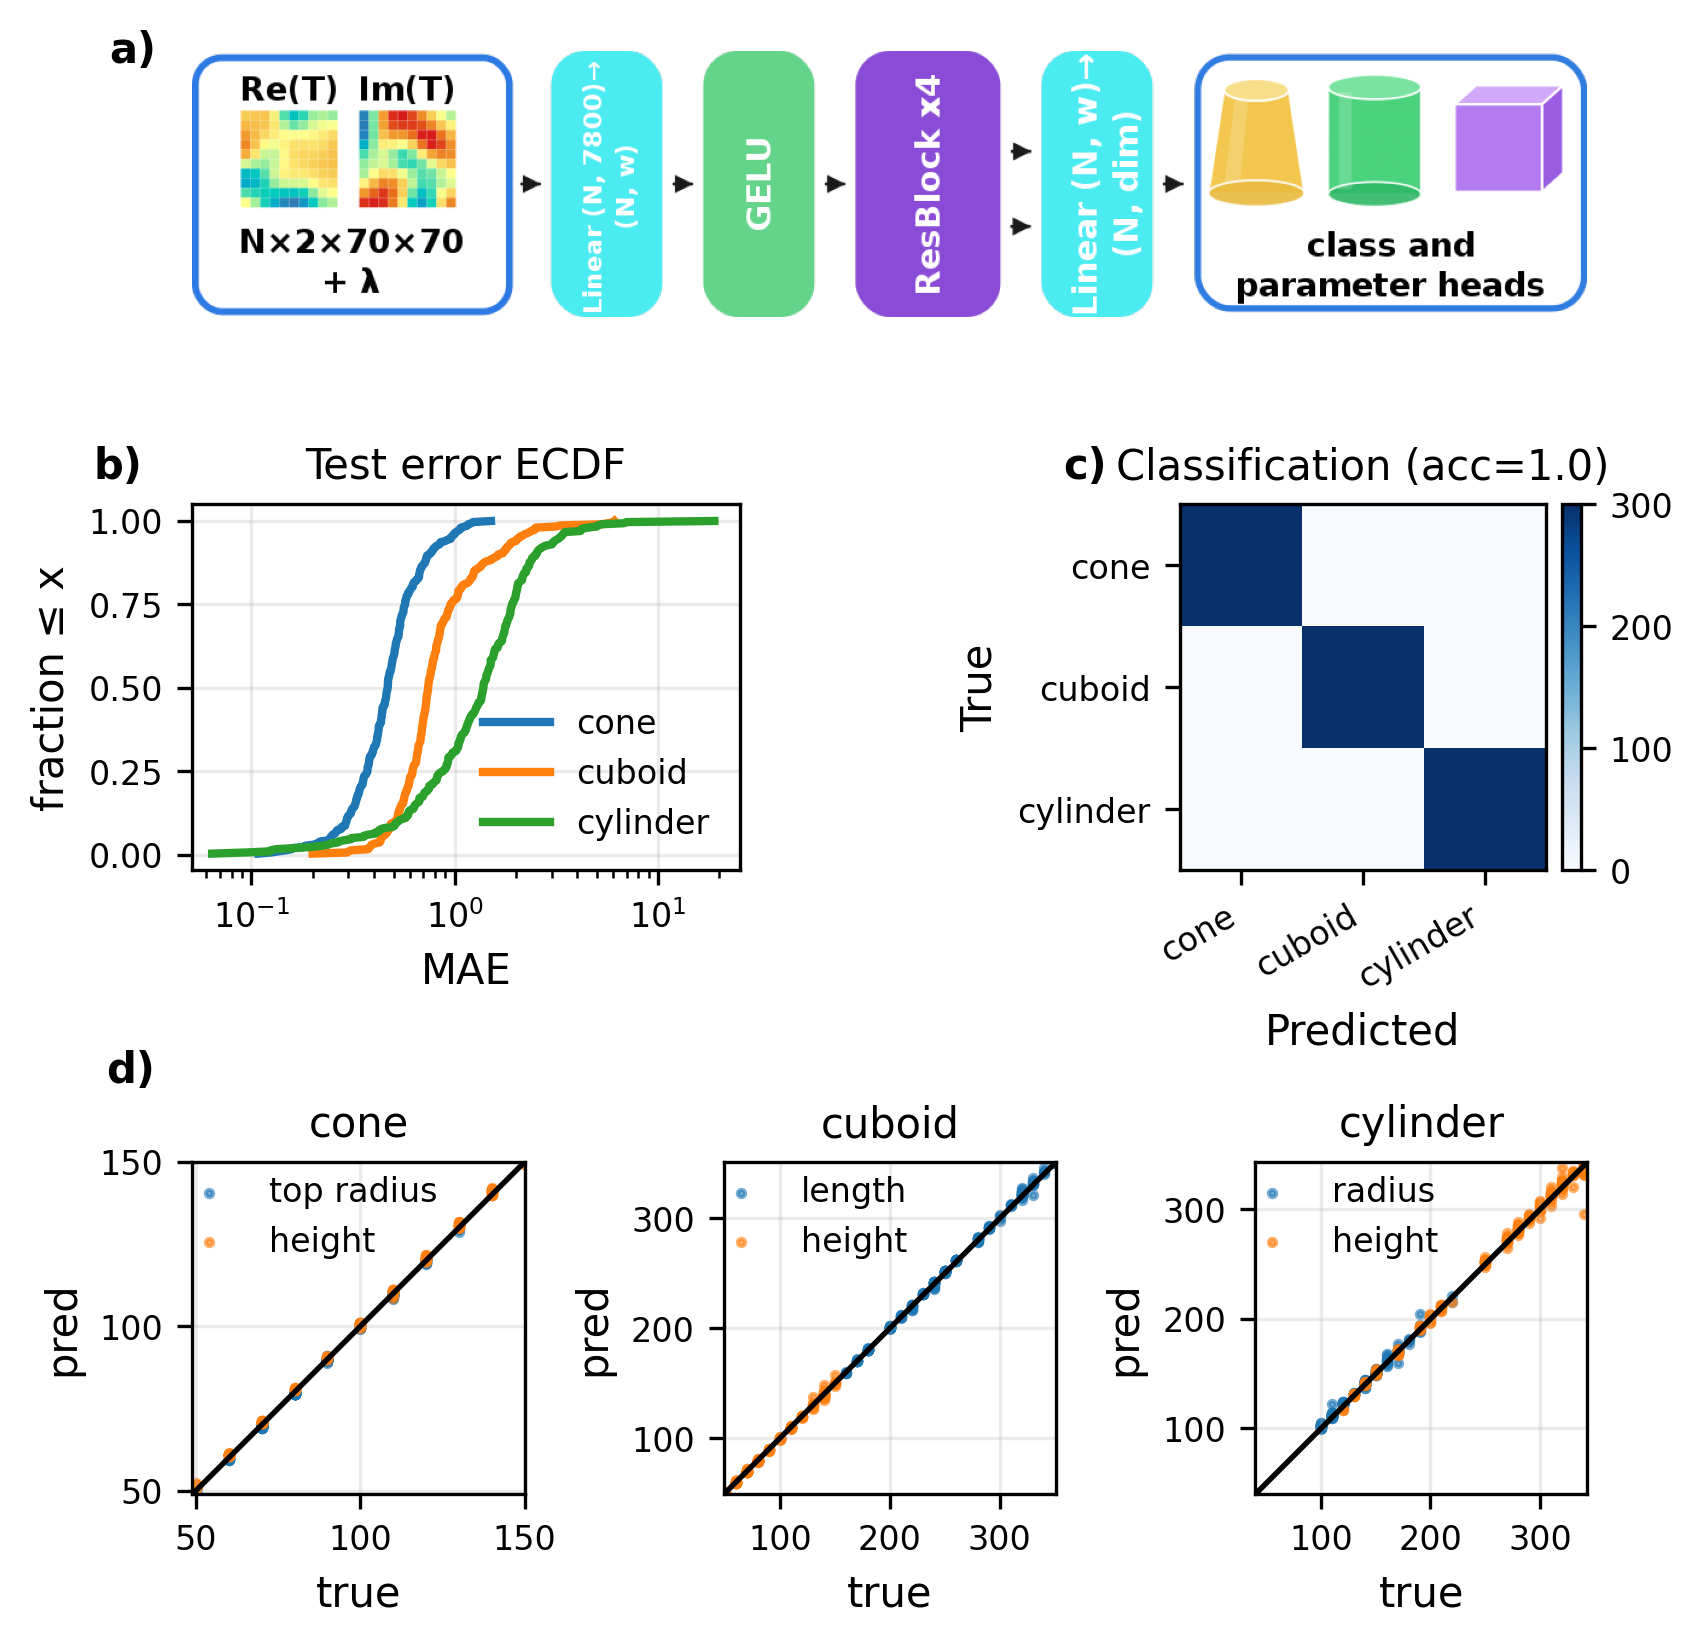

In [3]:
#!/usr/bin/env python3
"""
Load saved HDF5 
Plotting only
"""

import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def _decode_str_list(a):
    out = []
    for x in np.asarray(a).ravel():
        if isinstance(x, (bytes, np.bytes_)):
            out.append(x.decode("utf-8"))
        else:
            out.append(str(x))
    return out

def weighted_quantile(x, w, qs):
    x = np.asarray(x).ravel()
    w = np.asarray(w).ravel()
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    order = np.argsort(x)
    x, w = x[order], w[order]
    cw = np.cumsum(w) / np.sum(w)
    return np.interp(qs, cw, x)

def geom_fair_weights(gid):
    gid = np.asarray(gid).ravel()
    uniq, counts = np.unique(gid, return_counts=True)
    cdict = dict(zip(uniq, counts))
    return np.array([1.0 / cdict[g] for g in gid], dtype=float)



def summarize_by_class(err, y, gid, thresholds=(0.02, 0.05, 0.10)):
    err = np.asarray(err).ravel()
    y   = np.asarray(y).ravel().astype(int)
    gid = np.asarray(gid).ravel()
    w_all = geom_fair_weights(gid)

    out = {}
    for c in np.unique(y):
        m = (y == c)
        q50, q90 = weighted_quantile(err[m], w_all[m], [0.5, 0.9])
        fracs = {t: float(np.sum(w_all[m][err[m] <= t]) / np.sum(w_all[m])) for t in thresholds}
        out[int(c)] = dict(median=q50, p90=q90, frac=fracs, n=int(m.sum()))
    return out


def load_eval_plot_h5(path):
    with h5py.File(path, "r") as f:
        dump = {k: f["dump"][k][...] for k in f["dump"].keys()}
        if "mask" in dump:
            dump["mask"] = dump["mask"].astype(bool)

        delta = float(f["meta"]["delta"][()])
        class_names = _decode_str_list(f["meta"]["class_names"][...])
        def decode_arr(a):
            print("dtype", a.dtype.kind)
            if a.dtype.kind in ("S", "O"):
                return np.array([x.decode("utf-8") if isinstance(x, (bytes, np.bytes_)) else str(x) for x in a])
            return a

        parity_spec = {}
        gp = f["meta"]["parity_spec"]
        for key in gp.keys():
            cls = int(key.split("_")[-1])
            dims = gp[key]["dims"][...].astype(int).tolist()
            names = _decode_str_list(gp[key]["names"][...])
            parity_spec[cls] = list(zip(dims, names))

    top_img = plt.imread("figs/ttop.png") 

    return dump, class_names, parity_spec, delta, top_img


def per_sample_masked_mae(dump):
    y_true = np.asarray(dump["y_true"], float)
    y_pred = np.asarray(dump["y_pred"], float)
    mask = np.asarray(dump["mask"], bool)

    absd = np.abs(y_pred - y_true)
    absd[~mask] = np.nan
    err = np.nanmean(absd, axis=1)
    return np.nan_to_num(err, nan=0.0)


def plot_eval_summary_with_top_img(
    dump, 
    class_names,
    parity_spec,
    top_img=None,
    figsize=(6, 7),
    top_row_height=0.55,
    top_img_aspect="equal",
    out_png=None
):
    k_true = np.asarray(dump["k_true"], int)
    k_pred = np.asarray(dump["k_pred"], int)
    y_true = np.asarray(dump["y_true"], float)
    y_pred = np.asarray(dump["y_pred"], float)
    mask = np.asarray(dump["mask"], bool)

    K = len(class_names)
    conf = confusion_matrix(k_true, k_pred, labels=np.arange(K))
    acc = float((k_true == k_pred).mean())

    err = per_sample_masked_mae(dump)

    #stats = summarize_by_class(err, y_true, te_gid)
    
    fig = plt.figure(figsize=figsize)
    outer = fig.add_gridspec(3, 1, height_ratios=[top_row_height, 0.6, 1.0], hspace=0.35)

    # (a) top image
    if top_img is not None:
        ax_top = fig.add_subplot(outer[0, 0])
        ax_top.imshow(top_img, aspect=top_img_aspect)
        ax_top.set_xticks([])
        ax_top.set_yticks([])
        for sp in ax_top.spines.values():
            sp.set_visible(False)
        ax_top.text(-0.06, 1.08, "a)", transform=ax_top.transAxes,
                    fontweight="bold", ha="left", va="top")
    else:
        ax_top = None

    # row 2: ecdf + confusion
    mid = outer[1].subgridspec(1, 2, width_ratios=[1.0, 1.0], wspace=0.55)
    ax_ecdf = fig.add_subplot(mid[0, 0])
    ax_cm = fig.add_subplot(mid[0, 1])

    # row 3: parity panels
    bot = outer[2].subgridspec(1, 3, wspace=0.60)
    ax_par = [fig.add_subplot(bot[0, i]) for i in range(3)]

    # (b) ecdf
    for c, name in enumerate(class_names):
        x = np.sort(err[k_true == c])
        if x.size == 0:
            continue
        y = np.arange(1, x.size + 1) / x.size
        ax_ecdf.plot(x, y, lw=2, label=f"{name}")

    ax_ecdf.set_xscale("log")
    x_pos = err[(err > 0) & np.isfinite(err)]
    if x_pos.size:
        ax_ecdf.set_xlim(left=max(1e-6, 0.8 * x_pos.min()))

    ax_ecdf.set_xlabel("MAE")
    ax_ecdf.set_ylabel("fraction ≤ x")
    ax_ecdf.set_title("Test error ECDF")
    ax_ecdf.grid(alpha=0.25)
    ax_ecdf.legend(fontsize=8, frameon=False)
    ax_ecdf.text(-0.18, 1.16, "b)", transform=ax_ecdf.transAxes,
                 fontweight="bold", ha="left", va="top")

    # (c) confusion matrix
    im = ax_cm.imshow(conf, cmap="Blues")
    ax_cm.set_title(f"Classification (acc={acc:.1f})")
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("True")
    ax_cm.set_xticks(range(K))
    ax_cm.set_yticks(range(K))
    ax_cm.set_xticklabels(class_names, rotation=30, ha="right")
    ax_cm.set_yticklabels(class_names)
    fig.colorbar(im, ax=ax_cm, fraction=0.046, pad=0.03)
    ax_cm.text(-0.32, 1.16, "c)", transform=ax_cm.transAxes,
               fontweight="bold", ha="left", va="top")

    # (d) parity panels
    for c in range(min(3, K)):
        ax = ax_par[c]
        spec = parity_spec.get(c, [])
        dims = [d for d, _ in spec]

        m = k_true == c
        m_valid = m.copy()
        for d in dims:
            m_valid &= mask[:, d]

        yt = y_true[m_valid]
        yp = y_pred[m_valid]
        N = yt.shape[0]

        if N > 0 and len(dims) > 0:
            both = np.r_[yt[:, dims].ravel(), yp[:, dims].ravel()]
            lo, hi = np.percentile(both, [0.5, 99.5])
        else:
            lo, hi = 0.0, 1.0

        for d, name in spec:
            ax.scatter(yt[:, d], yp[:, d], s=3, alpha=0.6, label=name)

        ax.plot([lo, hi], [lo, hi], lw=1.3, color="k")
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_aspect("equal", adjustable="box")

        ax.set_title(f"{class_names[c]}")
        ax.set_xlabel("true")
        ax.set_ylabel("pred")
        ax.grid(alpha=0.25)
        ax.legend(fontsize=8, frameon=False, bbox_to_anchor=(-0.14, 1.05), loc="upper left")

    ax_par[0].text(-0.26, 1.34, "d)", transform=ax_par[0].transAxes,
                   fontweight="bold", ha="left", va="top")
    if out_png:
        fig.savefig(out_png, dpi=600, bbox_inches="tight")

    plt.show()
    return fig


def main():
    mpl.rcParams["figure.dpi"] = 300
    fs = 10
    mpl.rcParams.update(
        {
            "font.size": fs,
            "axes.titlesize": fs,
            "axes.labelsize": fs,
            "xtick.labelsize": fs - 2,
            "ytick.labelsize": fs - 2,
            "legend.fontsize": fs - 2,
            "figure.titlesize": fs,
        }
    )

    path = "results/ttoparam_results.h5"
    dump, class_names, parity_spec, delta, top_img = load_eval_plot_h5(path)

    plot_eval_summary_with_top_img(
        dump,
        class_names=class_names,
        parity_spec=parity_spec,
        top_img=top_img,
        figsize=(6, 7),
        top_row_height=0.55,
        top_img_aspect="equal",
        out_png="figs/figure_6.png",
    )


if __name__ == "__main__":
    main()


